In [1]:
#Import important libraries
import numpy as np
import pandas as pd
import seaborn as sbn
import import_ipynb
import TimeSeriesFitting as ts #Notebook with GARCH model
import fit_distribution_MLE as dist_MLE #Notebook with t-distribution related functions
import tCopula as tCopula #Notebook with tCopula functions

In [2]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import scipy.stats.distributions as dist
import statsmodels.graphics.tsaplots as tsaplots

In [3]:
#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Visualization & Pre-processing

In [4]:
#Read equities and treasury yield time-series data
amzn = pd.read_csv('AMZN.csv')
amd = pd.read_csv('AMD.csv')
nvda = pd.read_csv('NVDA.csv')
yield_hist = pd.read_csv('TreasuryYield.csv')

In [5]:
#Get the dates for each time-series
amzn_dates=pd.to_datetime(amzn['Date'])
amd_dates=pd.to_datetime(amd['Date'])
nvda_dates=pd.to_datetime(nvda['Date'])
yield_dates=pd.to_datetime(yield_hist['Date'])

In [6]:
#Get common dates between equities & treasury yields
common_idx_yield=np.intersect1d(yield_dates, amd_dates,return_indices=True)
common_idx_eq=np.intersect1d(amd_dates, yield_dates,return_indices=True)

In [7]:
yield_hist_ts=yield_hist.iloc[common_idx_yield[1],1:]
amzn_hist_ts=amzn.iloc[common_idx_eq[1],1:]
amd_hist_ts=amd.iloc[common_idx_eq[1],1:]
nvda_hist_ts=nvda.iloc[common_idx_eq[1],1:]

In [8]:
#Convert prices into log-returns
amzn_rets=np.diff(np.log(amzn_hist_ts['Adj Close']))
amd_rets=np.diff(np.log(amd_hist_ts['Adj Close']))
nvda_rets=np.diff(np.log(nvda_hist_ts['Adj Close'])) 
yield_rets=yield_hist_ts.diff(axis=0)
yield_rets=yield_rets.dropna()

In [9]:
#Construct dataframe of equities & yields
eq_df=pd.DataFrame(data=np.array([amzn_rets, amd_rets, nvda_rets]).T, columns=['AMZN','AMD','NVDA'])
yield_rets.reset_index(inplace=True)
yield_rets.drop(columns=['index'], inplace=True)
eq_yield_df=pd.concat([eq_df, yield_rets], axis=1, join='inner')

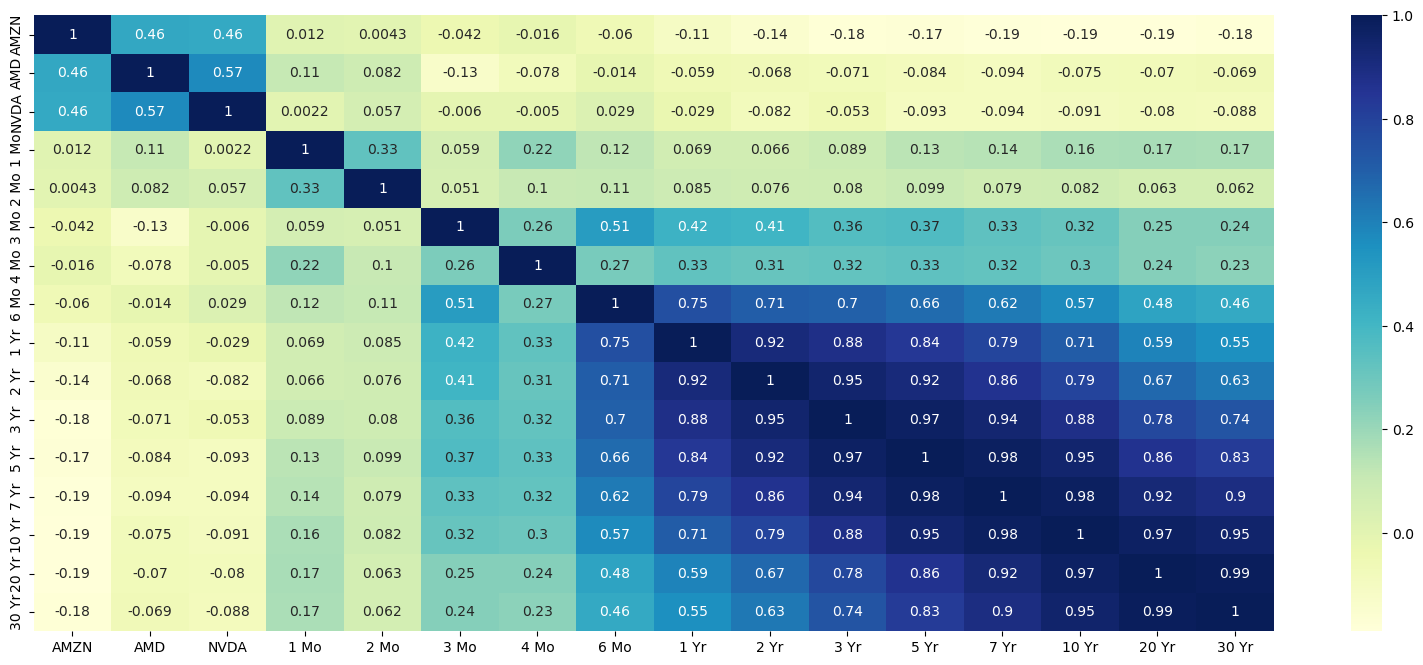

In [10]:
pyplot.figure(figsize=(20,8))
sbn.heatmap(eq_yield_df.corr(), annot=True,cmap="YlGnBu")
pyplot.show()

From the empirical data, it can be seen all 3 tech stocks exhibit negative low correlation with yield returns. Only AMZN has some significant correlation of ~-20% with longer maturity yields. 

# Yield curve Principal Component Analysis

In [11]:
#Do PCA on Yield Returns
pca_obj=PCA(n_components=3)
#pca_obj.fit(yield_rets)
pca_obj.fit(yield_hist_ts)

PCA(n_components=3)

In [12]:
#Get explained variance and principal components
print(pca_obj.explained_variance_ratio_.sum())
yield_pca_comps=pca_obj.components_

0.990440670719152


In [13]:
#Construct time-series for first 3 PCs
first_pca_ts=yield_pca_comps[0]*yield_hist_ts
second_pca_ts=yield_pca_comps[1]*yield_hist_ts
third_pca_ts=yield_pca_comps[2]*yield_hist_ts
first_pca_ts=first_pca_ts.sum(axis=1)
second_pca_ts=second_pca_ts.sum(axis=1)
third_pca_ts=third_pca_ts.sum(axis=1)
first_pca_ts.reset_index(drop=True, inplace=True)
second_pca_ts.reset_index(drop=True, inplace=True)
third_pca_ts.reset_index(drop=True, inplace=True)

In [14]:
#Check the quality of decomposition by reconstructing the original yield time-series
pca_arr=np.array([first_pca_ts, second_pca_ts, third_pca_ts]).T
recovered_yields=np.matmul(pca_arr, yield_pca_comps)
recovered_yields=pd.DataFrame(data=recovered_yields, columns=yield_rets.columns)

Text(0.5, 1.0, 'Recovered vs. Original Corr')

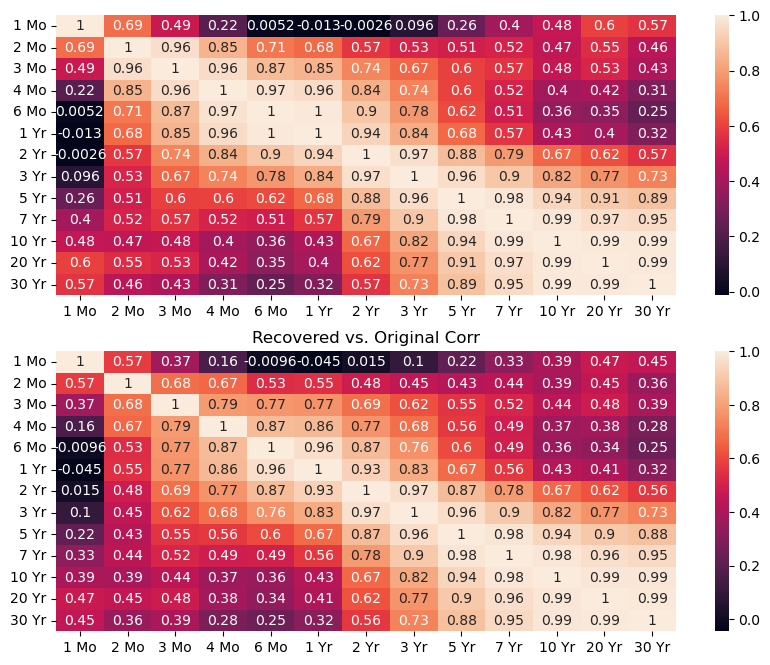

In [15]:
#Checking how much correlation is recovered by reconstructed yield curve from PCA
figure, (ax1, ax2)=pyplot.subplots(nrows=2, figsize=(10,8))
sbn.heatmap(recovered_yields.corr(), annot=True, ax=ax1)
sbn.heatmap(yield_hist_ts.corr(), annot=True, ax=ax2)
pyplot.title("Recovered vs. Original Corr")

Text(0.5, 1.0, 'Third PC')

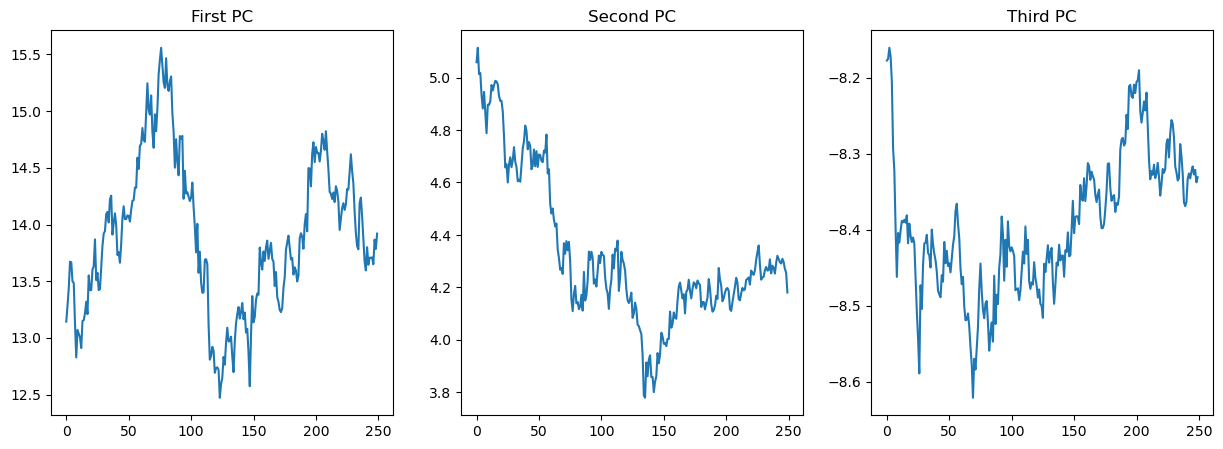

In [16]:
#Plot time-series for first 3 principal components.
fig, axs=pyplot.subplots(ncols=3, figsize=(15,5))
axs[0].plot(first_pca_ts)
axs[0].set_title("First PC")
axs[1].plot(second_pca_ts)
axs[1].set_title("Second PC")
axs[2].plot(third_pca_ts)
axs[2].set_title("Third PC")

# Equities & Yields time-series modeling

### Check for heteroskedacity

[Text(0.5, 1.0, 'NVDA.csv')]

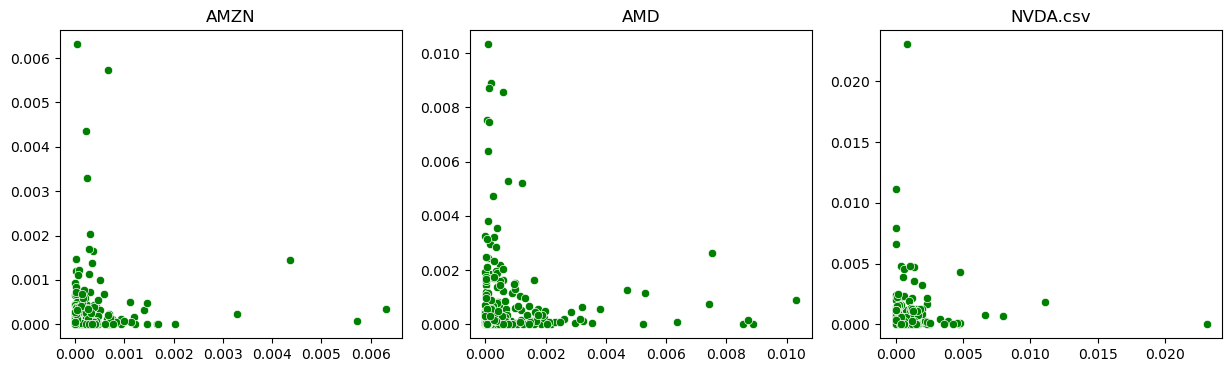

In [17]:
#Check heteroskedacity in equity log-returns by plotting squarred lagged residuals
figure, (ax1,ax2,ax3)= pyplot.subplots(ncols=3, figsize=(15,4))
sbn.scatterplot(x=amzn_rets[0:-1]**2, y=amzn_rets[1:]**2, ax=ax1, color='g').set(title='AMZN')
sbn.scatterplot(x=amd_rets[0:-1]**2, y=amd_rets[1:]**2, ax=ax2, color='g').set(title='AMD')
sbn.scatterplot(x=nvda_rets[0:-1]**2, y=nvda_rets[1:]**2, ax=ax3, color='g').set(title='NVDA.csv')


In [18]:
#Construct log-return time-series for the principal components
first_pca_ret_ts=np.diff(first_pca_ts)
second_pca_ret_ts=np.diff(second_pca_ts)
third_pca_ret_ts=np.diff(third_pca_ts)


Text(0.5, 1.0, 'Third PC')

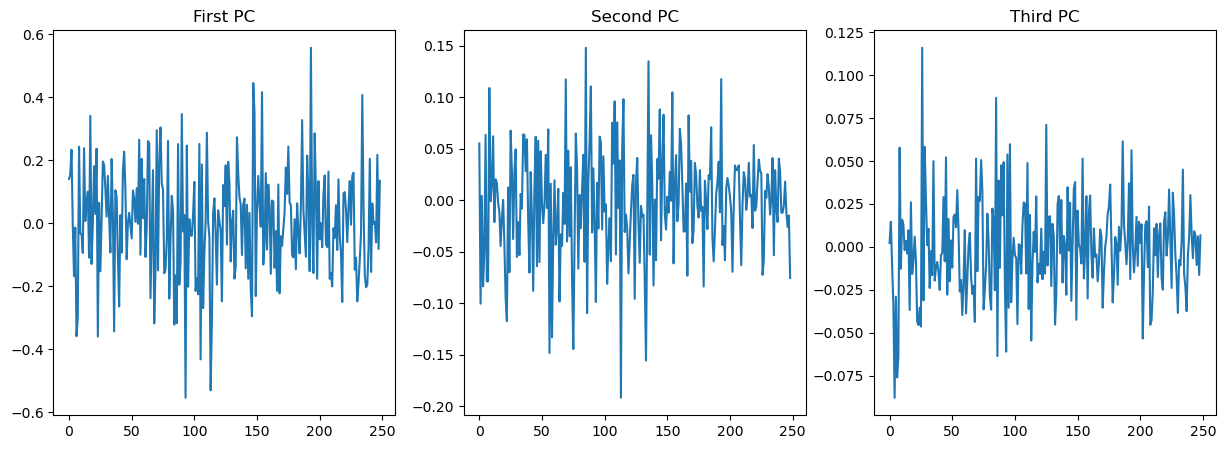

In [19]:
#Plot time-series for returns in first 3 principal components.
fig, axs=pyplot.subplots(ncols=3, figsize=(15,5))
axs[0].plot(first_pca_ret_ts)
axs[0].set_title("First PC")
axs[1].plot(second_pca_ret_ts)
axs[1].set_title("Second PC")
axs[2].plot(third_pca_ret_ts)
axs[2].set_title("Third PC")

<Axes: >

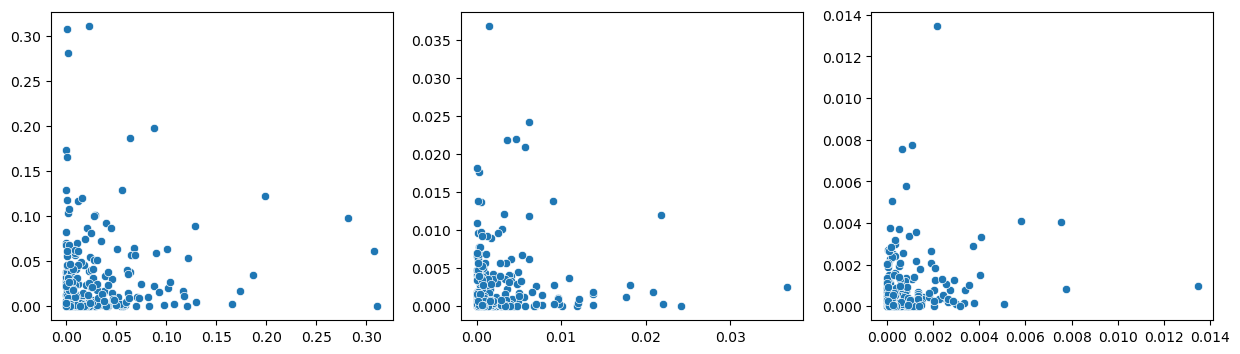

In [20]:
#Check heteroskedacity in yield returns by plotting squarred lagged residuals
figure, (ax1,ax2,ax3)= pyplot.subplots(ncols=3, figsize=(15,4))
sbn.scatterplot(x=first_pca_ret_ts[0:-1]**2, y=first_pca_ret_ts[1:]**2, ax=ax1)
sbn.scatterplot(x=second_pca_ret_ts[0:-1]**2, y=second_pca_ret_ts[1:]**2, ax=ax2)
sbn.scatterplot(x=third_pca_ret_ts[0:-1]**2, y=third_pca_ret_ts[1:]**2, ax=ax3)

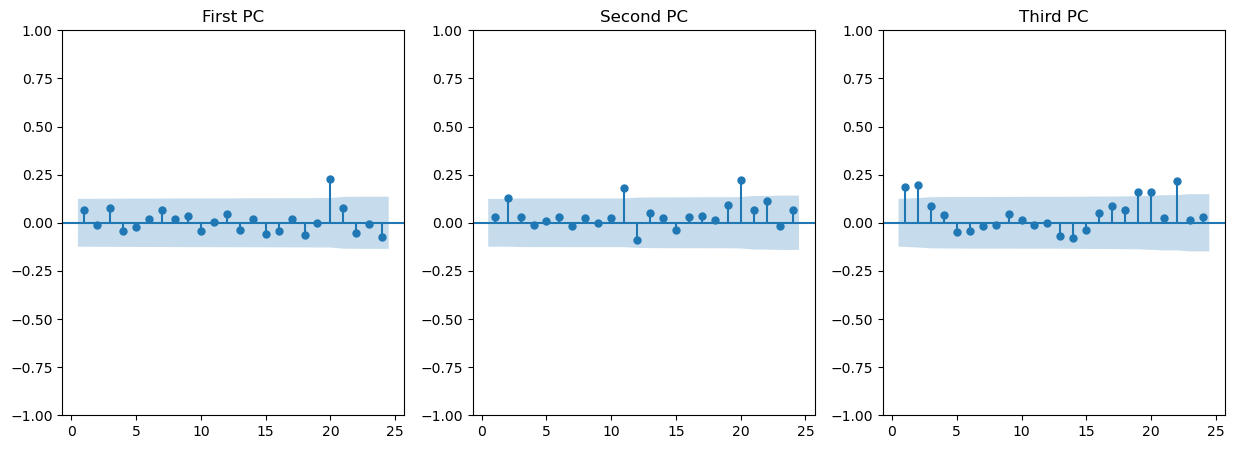

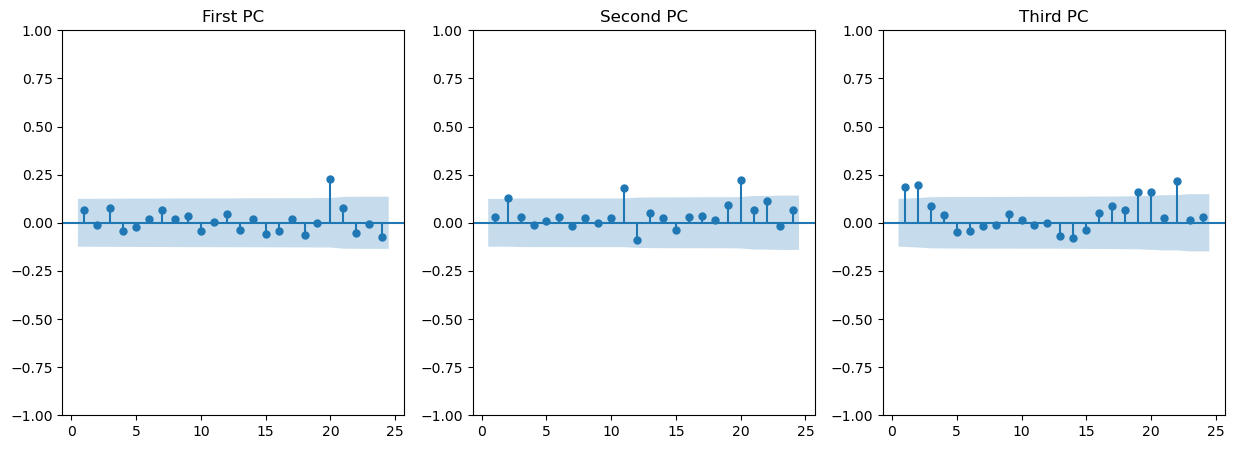

In [21]:
#Plot autocorrelation plots for 3 PCs
fig, axs=pyplot.subplots(ncols=3, figsize=(15,5))
tsaplots.plot_acf(first_pca_ret_ts**2, zero=False, ax=axs[0], title='First PC')
tsaplots.plot_acf(second_pca_ret_ts**2, zero=False, ax=axs[1], title='Second PC')
tsaplots.plot_acf(third_pca_ret_ts**2, zero=False, ax=axs[2], title='Third PC')

<Axes: ylabel='Count'>

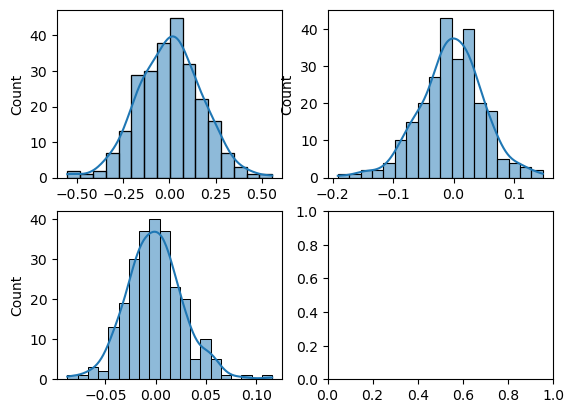

In [22]:
#Histograms for 3 PCs
fig, ((ax1,ax2), (ax3, ax4))=pyplot.subplots(nrows=2, ncols=2)
sbn.histplot(first_pca_ret_ts, kde=True, ax=ax1)
sbn.histplot(second_pca_ret_ts, kde=True, ax=ax2)
#sbn.histplot(third_pca_residuals_comp, kde=True, ax=ax3)
sbn.histplot(third_pca_ret_ts, kde=True, ax=ax3)

###### Some heteroskedactity is observed in all the risk factors. Though from the auto-correlation plots, it does not seem to be  Lag-1 for 1st and 2nd principal components.

In [23]:
#Create financial time series objects for equities & PCs
amzn_ts=ts.__FinTimeSeries__(amzn_rets)
amd_ts=ts.__FinTimeSeries__(amd_rets)
nvda_ts=ts.__FinTimeSeries__(nvda_rets)
pc1_ret_ts=ts.__FinTimeSeries__(first_pca_ret_ts)
pc2_ret_ts=ts.__FinTimeSeries__(second_pca_ret_ts)
pc3_ret_ts=ts.__FinTimeSeries__(third_pca_ret_ts)

In [24]:
#Fit econometrics models on each series
amzn_ts.fitGARCH()
amd_ts.fitGARCH()
nvda_ts.fitGARCH()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8798001582.913797
Iteration:      2,   Func. Count:     17,   Neg. LLF: 80331.68375447845
Iteration:      3,   Func. Count:     28,   Neg. LLF: 85568.15286095008
Iteration:      4,   Func. Count:     39,   Neg. LLF: 80015.0742399682
Iteration:      5,   Func. Count:     50,   Neg. LLF: 85592.55346993994
Iteration:      6,   Func. Count:     61,   Neg. LLF: 843.3668621498914
Iteration:      7,   Func. Count:     70,   Neg. LLF: 112583.30437915373
Iteration:      8,   Func. Count:     80,   Neg. LLF: 1114.8652993815724
Iteration:      9,   Func. Count:     89,   Neg. LLF: 26298.469791795076
Iteration:     10,   Func. Count:     98,   Neg. LLF: -660.7459274612995
Optimization terminated successfully    (Exit mode 0)
            Current function value: -660.7459270050014
            Iterations: 14
            Function evaluations: 98
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 820518.114028

In [25]:
#Fit econometrics models on each principal component
pc1_ret_ts.fitGARCH()
pc2_ret_ts.fitGARCH()
pc3_ret_ts.fitGARCH()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32370.34744612874
Iteration:      2,   Func. Count:     15,   Neg. LLF: 385554472.9173336
Iteration:      3,   Func. Count:     23,   Neg. LLF: -83.3493308064564
Iteration:      4,   Func. Count:     31,   Neg. LLF: -84.83455862949396
Iteration:      5,   Func. Count:     36,   Neg. LLF: -50.49717053314008
Iteration:      6,   Func. Count:     43,   Neg. LLF: -84.82638937383915
Iteration:      7,   Func. Count:     49,   Neg. LLF: -84.83865144301194
Iteration:      8,   Func. Count:     54,   Neg. LLF: -84.83866117196072
Iteration:      9,   Func. Count:     58,   Neg. LLF: -84.83866117148483
Optimization terminated successfully    (Exit mode 0)
            Current function value: -84.83866117196072
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8564950.58709412
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2446884099672

#### GARCH(1,1) Parameters

In [26]:
#Get fitted parameters
amzn_params=amzn_ts.get_garch_params()
amd_params=amd_ts.get_garch_params()
nvda_params=nvda_ts.get_garch_params()
pc1_params=pc1_ret_ts.get_garch_params()
pc2_params=pc2_ret_ts.get_garch_params()
pc3_params=pc3_ret_ts.get_garch_params()

In [27]:
t_dof=pd.DataFrame(data=[amzn_params, amd_params, nvda_params, pc1_params, pc2_params, pc3_params], 
             index=['AMZN','AMD','NVDA','PC1','PC2','PC3'])

<Axes: >

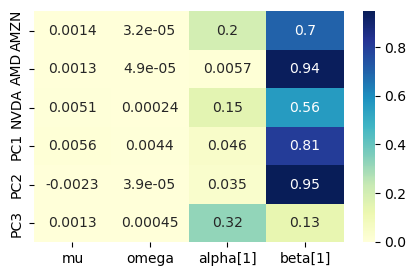

In [28]:
pyplot.figure(figsize=(5,3))
sbn.heatmap(t_dof, annot=True, cmap="YlGnBu")

In [29]:
#Get iid residuals for each series
amzn_iid_residuals = amzn_ts.get_iid_residuals()
amd_iid_residuals=amd_ts.get_iid_residuals()
nvda_iid_residuals=nvda_ts.get_iid_residuals()
pc1_iid_residuals=pc1_ret_ts.get_iid_residuals()
pc2_iid_residuals=pc2_ret_ts.get_iid_residuals()
pc3_iid_residuals=pc3_ret_ts.get_iid_residuals()

<Axes: >

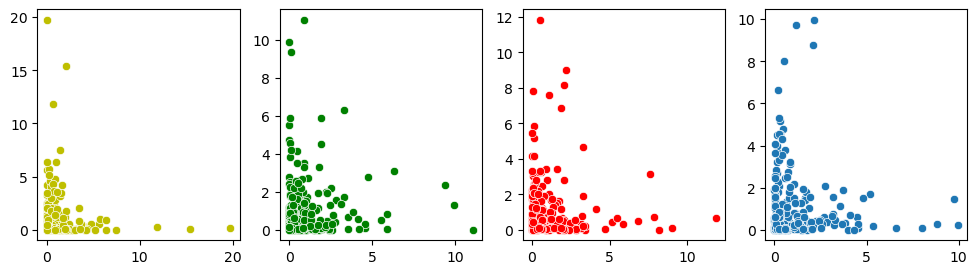

In [30]:
#Scatter plot for iid residuals to check if heteroskedacity still remains
figure, (ax1,ax2,ax3, ax4) = pyplot.subplots(ncols=4,figsize=(12,3))
sbn.scatterplot(x=amzn_iid_residuals[0:-1]**2, y=amzn_iid_residuals[1:]**2, color='y', ax=ax1)
sbn.scatterplot(x=pc1_iid_residuals[0:-1]**2, y=pc1_iid_residuals[1:]**2, color='g', ax=ax2)
sbn.scatterplot(x=pc2_iid_residuals[0:-1]**2, y=pc2_iid_residuals[1:]**2, color='r', ax=ax3)
sbn.scatterplot(x=pc3_iid_residuals[0:-1]**2, y=pc3_iid_residuals[1:]**2, ax=ax4)

#### It is observed that iid residuals also exhibit heteroskedacity, implying a better model than GARCH(1,1) can be used

# Correlation & t-Copula

In [31]:
#Try fitting different distributions on iid residuals
combined_iid_residuals=np.zeros((6, len(amd_iid_residuals)))
combined_iid_residuals[0][:]=amzn_iid_residuals
combined_iid_residuals[1][:]=amd_iid_residuals
combined_iid_residuals[2][:]=nvda_iid_residuals
combined_iid_residuals[3][:]=pc1_iid_residuals
combined_iid_residuals[4][:]=pc2_iid_residuals
combined_iid_residuals[5][:]=pc3_iid_residuals

In [32]:
#Get degrees of freedom for each risk factor
fitted_dofs=dist_MLE.fit_tdist_logMLE(combined_iid_residuals, np.arange(1,31)) 
print(fitted_dofs)

-0.006207873602917538
1.0110267388576168
-0.0037773453563362605
0.979597309282683
-0.009503037871039358
1.0390244926461318
-0.021511912724580806
0.9799429786413287
0.0067358317546344845
0.9604089311184449
-0.03337610694773587
0.9546224688633929
[ 8.  5.  5. 21. 13. 14.]


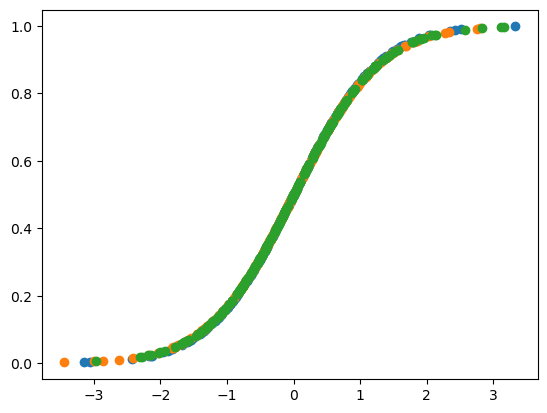

In [33]:
#Get uniform variates for risk factors and plot them
uniform_variates= dist_MLE.get_cdf_tdist(combined_iid_residuals, fitted_dofs)
pyplot.scatter(x=pc1_iid_residuals, y=uniform_variates[3][:])
pyplot.scatter(x=pc2_iid_residuals, y=uniform_variates[4][:])
pyplot.scatter(x=pc3_iid_residuals, y=uniform_variates[5][:])

In [34]:
#Get t-dist variates with dof=4 for equities and yield components
t_dof4_variates=dist_MLE.get_inverse_cdf(uniform_variates)

[Text(0.5, 1.0, 'Empirical')]

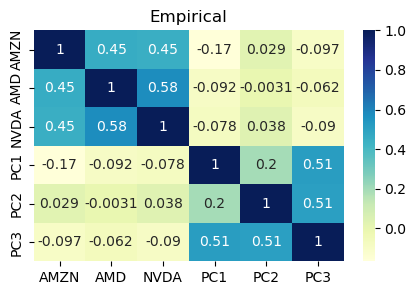

In [35]:
#Generate correlation among the equities t-variates
corrMatrix=np.corrcoef(t_dof4_variates)
corr_df=pd.DataFrame(corrMatrix,columns=['AMZN','AMD','NVDA','PC1','PC2','PC3'],index=['AMZN','AMD','NVDA','PC1','PC2','PC3'])
pyplot.figure(figsize=(5,3))
sbn.heatmap(corr_df, annot=True, cmap="YlGnBu").set(title='Empirical')

#### Construct a t-copula

In [36]:
#Create a t-copula class with the correlation matrix and generate t-scenarios
tCop = tCopula.tCopula(corrMatrix)
tScenarios=tCop.generate_random_variates(num_ts=6, num_scenarios=10000)

In [37]:
tScenarios_df=pd.DataFrame(data=tScenarios)
df=tScenarios_df.corr()
df.columns=['AMZN','AMD','NVDA','PC1','PC2','PC3']
df.index=['AMZN','AMD','NVDA','PC1','PC2','PC3']

[Text(0.5, 1.0, 't-Copula')]

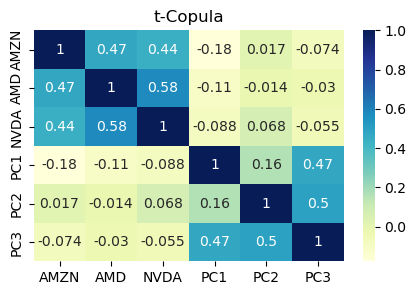

In [38]:
pyplot.figure(figsize=(5,3))
sbn.heatmap(df, annot=True, cmap="YlGnBu").set(title='t-Copula')

# Generate equity and yield scenarios

In [39]:
#Generate equities log return scenarios based on iid residual scenarios
def generate_return_scenarios(garch_params, random_variates, last_vol, last_epsilon):
     next_cond_vol = np.sqrt(garch_params[1] + garch_params[2]*(last_epsilon**2) + garch_params[3]*(last_vol**2)) 
     next_epsilon_scenarios = next_cond_vol*random_variates
     next_ret_scenarios = garch_params[0]+ next_epsilon_scenarios
     return next_ret_scenarios   


In [40]:
#Get last conditional vol and epsilon/main residuals
amzn_cond_vols = amzn_ts.get_conditional_vol()
amd_cond_vols = amd_ts.get_conditional_vol()
nvda_cond_vols = nvda_ts.get_conditional_vol()
pc1_cond_vols = pc1_ret_ts.get_conditional_vol()
pc2_cond_vols = pc2_ret_ts.get_conditional_vol()
pc3_cond_vols = pc3_ret_ts.get_conditional_vol()

In [41]:
#Get forecasted returns for equities
amzn_last_epsilon=amzn_rets[-1]-amzn_params[0]
amzn_ret_scenarios = generate_return_scenarios(amzn_params, tScenarios.T[0][:],amzn_cond_vols[-1],amzn_last_epsilon)
amd_last_epsilon=amd_rets[-1]-amd_params[0]
amd_ret_scenarios = generate_return_scenarios(amd_params, tScenarios.T[1][:],amd_cond_vols[-1],amd_last_epsilon)
nvda_last_epsilon=nvda_rets[-1]-nvda_params[0]
nvda_ret_scenarios = generate_return_scenarios(nvda_params, tScenarios.T[2][:],nvda_cond_vols[-1],nvda_last_epsilon)

In [42]:
#Get simple return scenarios for the 3 princial components
pc1_last_epsilon=first_pca_ret_ts[-1]-pc1_params[0]
pc1_ret_scenarios = generate_return_scenarios(pc1_params, tScenarios.T[3][:],pc1_cond_vols[-1],pc1_last_epsilon)
pc2_last_epsilon=second_pca_ret_ts[-1]-pc2_params[0]
pc2_ret_scenarios = generate_return_scenarios(pc2_params, tScenarios.T[4][:],pc2_cond_vols[-1],pc2_last_epsilon)
pc3_last_epsilon=third_pca_ret_ts[-1]-pc3_params[0]
pc3_ret_scenarios = generate_return_scenarios(pc3_params, tScenarios.T[5][:],pc3_cond_vols[-1],pc3_last_epsilon)

In [43]:
first_pca_ts.reset_index(drop=True, inplace=True)
second_pca_ts.reset_index(drop=True, inplace=True)
third_pca_ts.reset_index(drop=True, inplace=True)

In [44]:
#From PCA return scenarios, get forecasted PCA values
pc1_val_scenarios=first_pca_ts.iloc[-1]+pc1_ret_scenarios
pc2_val_scenarios=second_pca_ts.iloc[-1]+pc2_ret_scenarios
pc3_val_scenarios=third_pca_ts.iloc[-1]+pc3_ret_scenarios
yield_pca_scenarios= np.array([pc1_val_scenarios,pc2_val_scenarios, pc3_val_scenarios])

In [45]:
#Recover yield curve scenarios from inverse transformation of principal components
yield_value_scenarios = np.dot(yield_pca_comps.T, yield_pca_scenarios)

In [46]:
#Generate yield/price values from yield return sceanrios
yield_value_scenarios_df=pd.DataFrame(data= yield_value_scenarios.T, columns=yield_hist_ts.columns)

[Text(0.5, 1.0, 'Simulated correlation across treasury curve')]

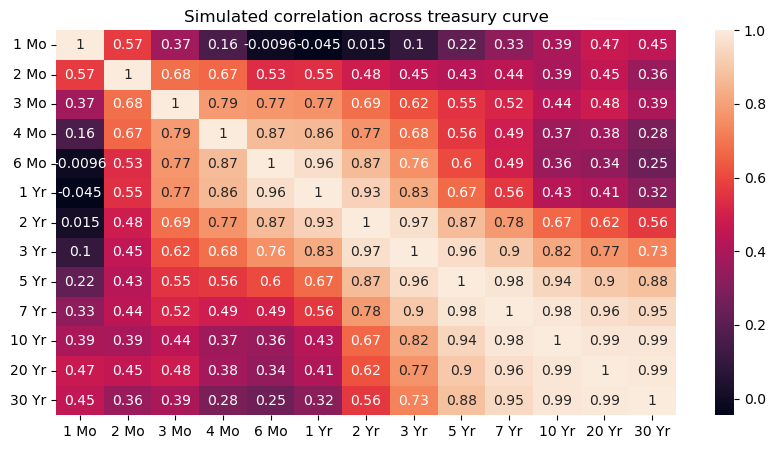

In [47]:
#Plot simulated correlation from yield values
pyplot.figure(figsize=(10,5))
sbn.heatmap(yield_hist_ts.corr(), annot=True).set(title='Simulated correlation across treasury curve')

<Axes: xlabel='10 Yr', ylabel='Count'>

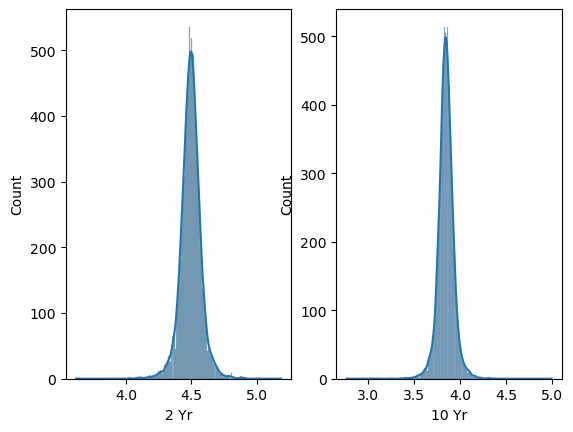

In [48]:
#Plot scenarios for 2-yr and 10-yr yield
fig, (ax1, ax2)=pyplot.subplots(ncols=2)
sbn.histplot(yield_value_scenarios_df['2 Yr'], kde=True, ax=ax1)
sbn.histplot(yield_value_scenarios_df['10 Yr'], kde=True,ax=ax2)


In [49]:
#Construct a dataframe with equity return and 2-yr yield returns
final_risk_factors=pd.DataFrame(data=np.array([amzn_ret_scenarios, amd_ret_scenarios, nvda_ret_scenarios,yield_value_scenarios_df['2 Yr']]).T, 
                                columns=['AMZN','AMD','NVDA','2YrYield'])                                                                                                                     

[Text(0.5, 1.0, 'Simulation')]

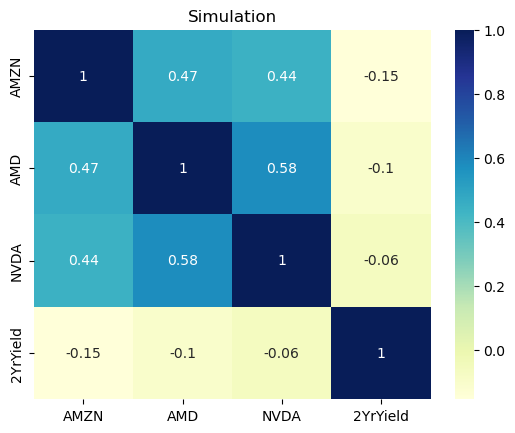

In [50]:
#Correlation across equities and 2-yr yield
sbn.heatmap(final_risk_factors.corr(),annot=True,cmap="YlGnBu").set(title="Simulation")

[Text(0.5, 1.0, 'Empirical')]

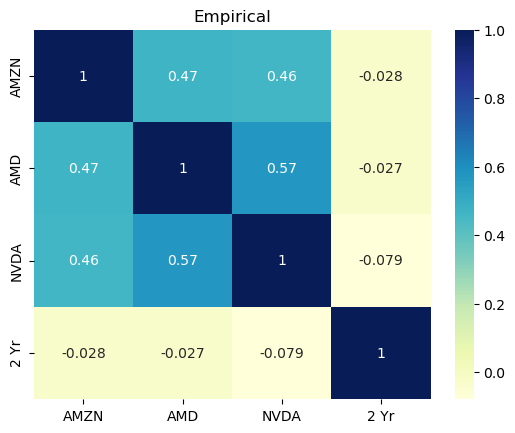

In [51]:
#Plot empirical correlation 
eq_2Yryield_df=pd.concat([eq_df, yield_hist_ts['2 Yr']], axis=1, join='inner')
sbn.heatmap(eq_2Yryield_df.corr(),annot=True,cmap="YlGnBu").set(title="Empirical")

In [52]:
#Generate yield return scenarios from yield value scenarios
current_yield_values=yield_hist_ts.iloc[-1]
yield_ret_scenarios=yield_value_scenarios_df - current_yield_values

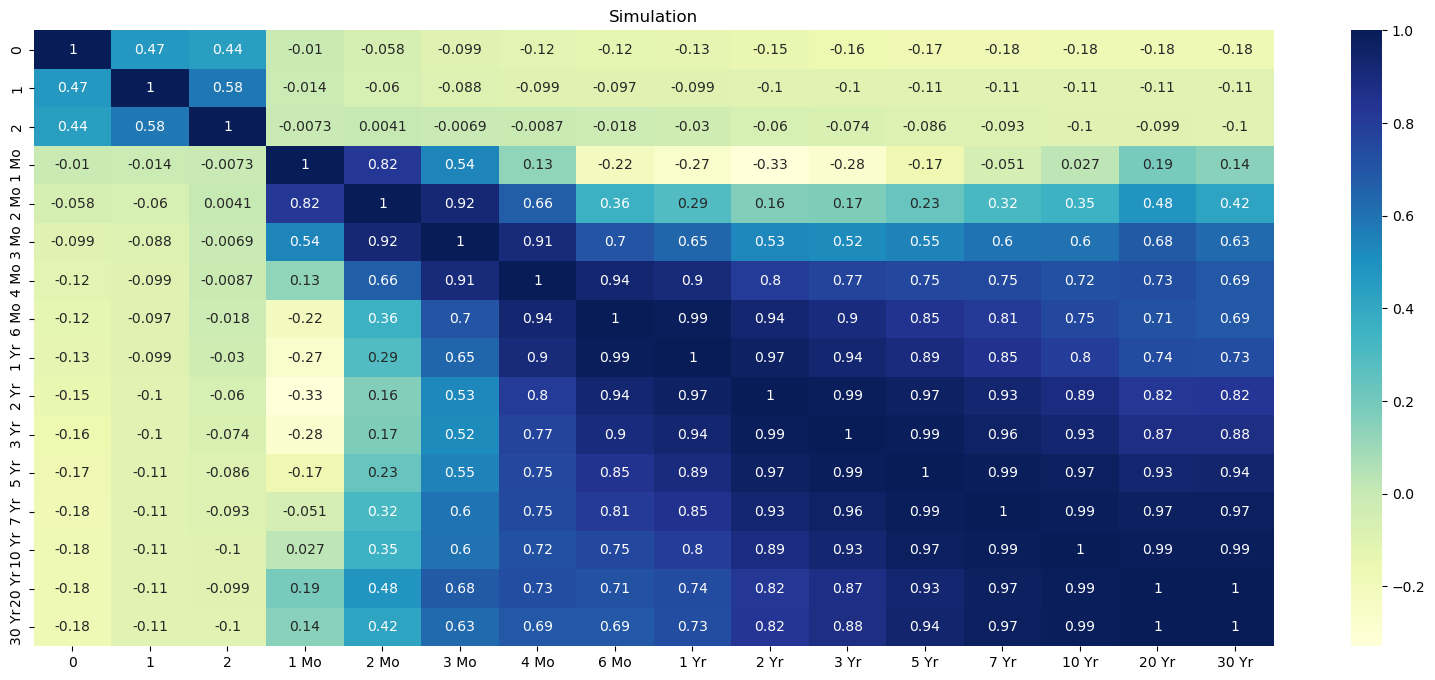

In [53]:
#Construct a dataframe with equity returns and 2-yr yield returns and plot corrrelation
final_risk_factors_all=pd.concat([pd.DataFrame(data=np.array([amzn_ret_scenarios, amd_ret_scenarios, nvda_ret_scenarios]).T),yield_ret_scenarios], axis=1)
pyplot.figure(figsize=(20,8))
sbn.heatmap(final_risk_factors_all.corr(), annot=True,cmap="YlGnBu").set(title="Simulation")
pyplot.show()                                
                                

In [54]:
#Price a treasury bond based on the yield scenarios
#Consider a bond with 2-year maturity, coupon frequency of 4 (every 3 months) and a coupon rate of 3.75%
timesToPayments = np.arange(0.25,2.25, 0.25)
coupon_rate=0.0375
yield_maturities=yield_rets.columns.tolist()
yield_maturities_yr=[float(mat.split()[0])/12 if mat.split()[1]=='Mo' else  int(mat.split()[0]) for mat in yield_maturities ]
#current_yields_arr=current_yield_values.reshape(len(current_yield_values))
yields_interpolated=np.interp(timesToPayments, xp=np.array(yield_maturities_yr), fp=np.array(current_yield_values))

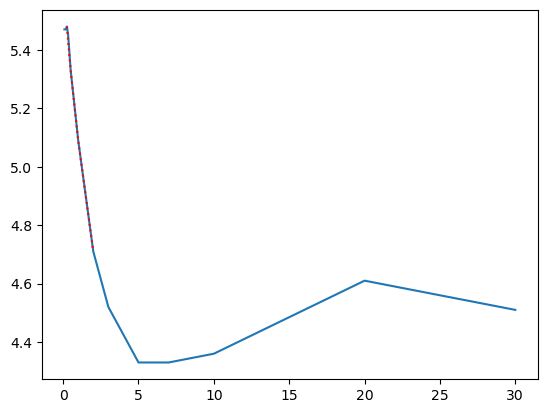

In [55]:
#Plot the interpolated yields to market data
pyplot.plot(np.array(yield_maturities_yr), current_yield_values)
pyplot.plot(timesToPayments, yields_interpolated, color='r', linestyle='dotted')

In [56]:
#Price bond - current value and scenario values
bond_curr_values=[(coupon_rate*0.25)/(1+y*mat*0.01) if mat < 1 else (coupon_rate*0.25)/(1+y*0.01)**mat for y, mat in zip(yields_interpolated, timesToPayments)]
bond_curr_val=sum(bond_curr_values[:-1])+ bond_curr_values[-1] + 1/(1+yields_interpolated[-1])**timesToPayments[-1]

In [57]:
yield_value_scenarios=yield_value_scenarios.T

In [58]:
#Price bond for each of the Scenarios
bond_scenarios=np.zeros(yield_value_scenarios.shape[0])
for count in np.arange(0,yield_value_scenarios.shape[0]):
    #Get interpolated yields
    yields_scenario_interpolated=np.interp(timesToPayments, xp=np.array(yield_maturities_yr), fp=np.array(yield_value_scenarios[count][:]))
    bond_scenario_values=[(coupon_rate*0.25)/(1+y*mat*0.01) if mat < 1 else (coupon_rate*0.25)/(1+y*0.01)**mat for y, mat in zip(yields_scenario_interpolated, timesToPayments)]
    bond_scenarios[count]=sum(bond_scenario_values[:-1])+ bond_scenario_values[-1] + 1/(1+yields_interpolated[-1])**timesToPayments[-1]

In [59]:
bond_scenarios.reshape(yield_value_scenarios.shape[0],1)

array([[0.1010061 ],
       [0.10105673],
       [0.10100327],
       ...,
       [0.10103004],
       [0.10103178],
       [0.10109367]])

<Axes: ylabel='Count'>

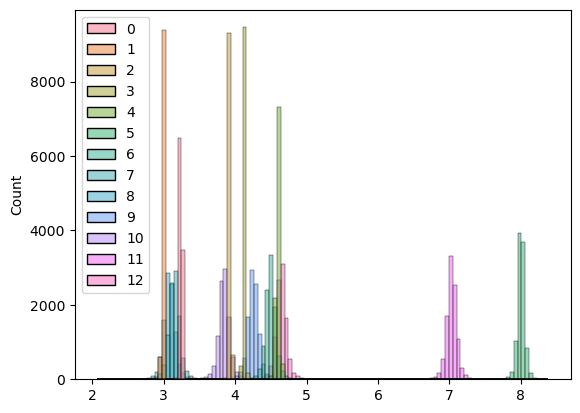

In [60]:
sbn.histplot(yield_value_scenarios)

[Text(0.5, 1.0, '2-yr treasury bond return portfolios')]

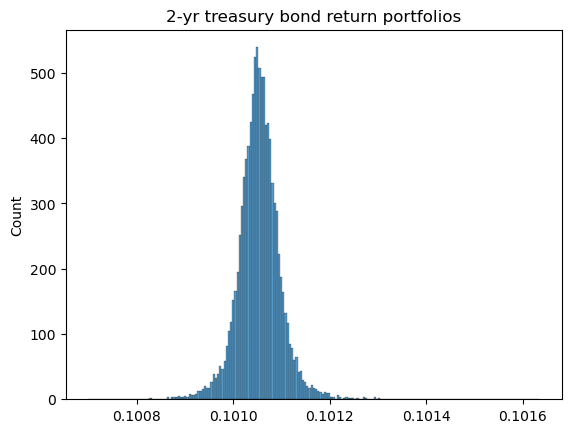

In [61]:
#Plot bond return scenarios
bond_ret_scenarios=bond_scenarios-bond_curr_val
sbn.histplot(bond_scenarios).set(title='2-yr treasury bond return portfolios')

# Portfolio Construction

The goal is construct a portfolio with optimal weights, i.e. minimize the variance with a target mean return

In [62]:
#Create equities-only portfolio scenarios
#long AMZN, long AMD, long NVDA
combined_port_scenarios =0.2*amzn_ret_scenarios+0.3*amd_ret_scenarios+0.5*nvda_ret_scenarios

[Text(0.5, 1.0, 'Only Equities')]

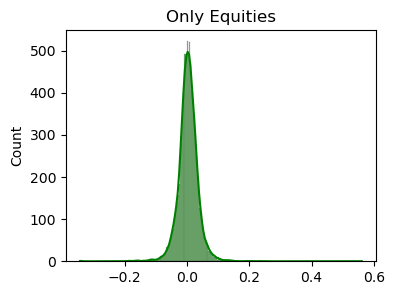

In [63]:
pyplot.figure(figsize=(4,3))
sbn.histplot(combined_port_scenarios, kde=True, color='g').set(title="Only Equities")

In [64]:
#Get Sharpe ratio and VaR for equities-only portfolio
sharpe_stock=np.mean(combined_port_scenarios)/ np.std(combined_port_scenarios)
var_stock=np.quantile(combined_port_scenarios, 0.05)
print("Sharpe ratio for equities portfolio is:", sharpe_stock)
print("Var at 95% confidence level for equities portfolio is:", var_stock)

Sharpe ratio for equities portfolio is: 0.10130355888874208
Var at 95% confidence level for equities portfolio is: -0.04522371945152484


In [65]:
#Create portfolio scenarios with bond
#long AMZN, long AMD, long NVDA. Long Bond
combined_stock_bond_scenarios =0.2*amzn_ret_scenarios+0.2*amd_ret_scenarios+0.5*nvda_ret_scenarios+0.1*bond_ret_scenarios

In [66]:
#Get Sharpe ratio and VaR for equities and bond portfolio
sharpe_stock_bond=np.mean(combined_stock_bond_scenarios)/ np.std(combined_stock_bond_scenarios)
var_stock_bond=np.quantile(combined_stock_bond_scenarios, 0.05)
print("Sharpe ratio for equities + bond portfolio is:", sharpe_stock_bond)
print("Var at 95% confidence level for equities + bond portfolio is:", var_stock_bond)

Sharpe ratio for equities + bond portfolio is: 0.1046764490966187
Var at 95% confidence level for equities + bond portfolio is: -0.04035821287339625


[Text(0.5, 1.0, 'Equities & 2-yr Bond')]

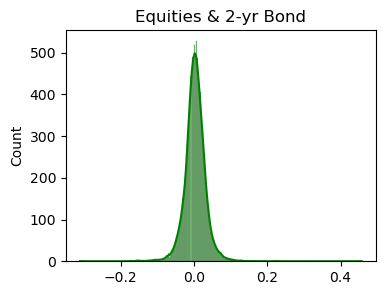

In [67]:
pyplot.figure(figsize=(4,3))
sbn.histplot(combined_stock_bond_scenarios, kde=True, color='g').set(title='Equities & 2-yr Bond')